#### Path to local libraries

In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [2]:
# Generic
import pandas as pd
import numpy as np
import math

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# ML Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

# Statistical Models
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from pmdarima import auto_arima


In [3]:
# Comment this line to render plotly into GitHub 
#pio.renderers.default = "svg"

In [4]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'FIN'

# Dependant variable (Orders or TIV)
dep_var = 'Orders'  

# Use feature eng/selection
feature_engineering = True
feature_selection = True

# Include rest of nordic countries as exogenous features
include_nordics = True

### Load data

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

In [6]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01,1124,0.807265,8.3,3.280000,203.413007
2006-02,1079,0.901804,8.0,3.440000,128.084250
2006-03,1210,0.899101,7.7,3.620000,151.605878
2006-04,1147,1.297405,7.7,3.880000,135.086704
2006-05,1001,1.701702,7.9,3.940000,166.978193
...,...,...,...,...,...
2022-08,254,7.616082,7.2,1.624904,78.449535
2022-09,228,8.119296,7.3,2.420836,74.997932
2022-10,188,8.310766,6.4,2.894486,68.348358


C:\Users\ne74255\AppData\Local\Temp/ipykernel_8264/2265466338.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.plot(


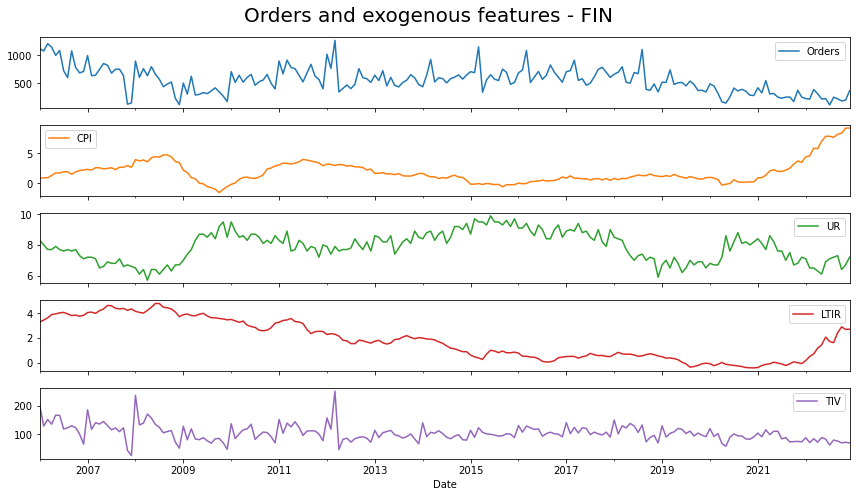

In [7]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 7))
df.plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    ax       = ax, 
)
fig.suptitle(dep_var + ' and exogenous features - ' + country, fontsize=20)
fig.tight_layout();

C:\Users\ne74255\AppData\Local\Temp/ipykernel_8264/15051175.py:16: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_nordics.plot(


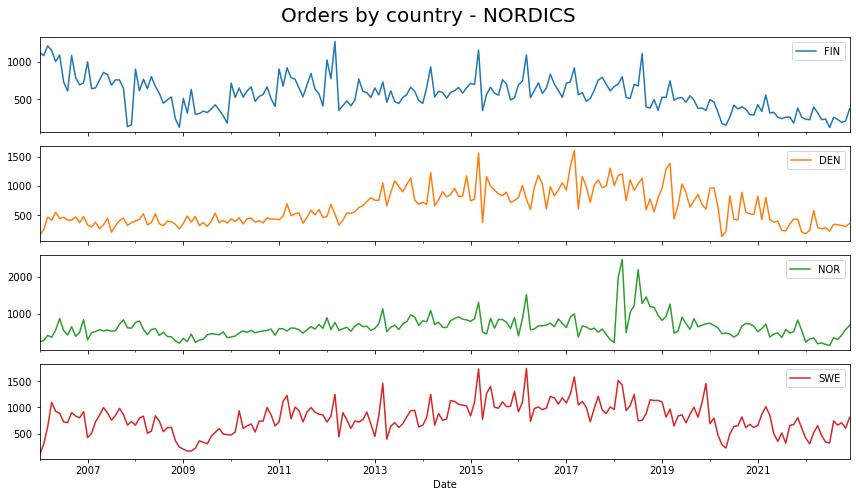

In [8]:
if include_nordics:
    # Load files into a pandas dataframes
    file = path + 'target.xlsx'

    df_nordics = pd.read_excel(file, sheet_name=dep_var)

    # Set index
    df_nordics = df_nordics.set_index("Date")
    df_nordics.index = pd.PeriodIndex(df_nordics.index, freq="M")

    df_nordics
    df = pd.merge(df, df_nordics[df_nordics.columns.difference([country])], left_index=True, right_index=True)

    # Plot time series
    fig, ax = plt.subplots(figsize=(12, 7))
    df_nordics.plot(
        legend   = True,
        subplots = True, 
        sharex   = True,
        ax       = ax, 
    )
    fig.suptitle(dep_var + ' by country - NORDICS', fontsize=20)
    fig.tight_layout();    

In [9]:
df

,Orders,CPI,UR,LTIR,TIV,DEN,NOR,SWE
Date,,,,,,,,
2006-01,1124,0.807265,8.3,3.280000,203.413007,161,233,110
2006-02,1079,0.901804,8.0,3.440000,128.084250,250,270,303
2006-03,1210,0.899101,7.7,3.620000,151.605878,468,406,634
2006-04,1147,1.297405,7.7,3.880000,135.086704,412,356,1097
2006-05,1001,1.701702,7.9,3.940000,166.978193,550,553,926
...,...,...,...,...,...,...,...,...
2022-08,254,7.616082,7.2,1.624904,78.449535,343,347,744
2022-09,228,8.119296,7.3,2.420836,74.997932,337,295,666
2022-10,188,8.310766,6.4,2.894486,68.348358,322,413,711


In [10]:
df.describe()

,Orders,CPI,UR,LTIR,TIV,DEN,NOR,SWE
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,562.715686,1.805420,7.889706,1.826215,103.698640,631.156863,633.328431,804.750000
std,230.914774,1.866685,0.957234,1.569162,29.790359,301.194068,305.915528,292.446469
min,118.000000,-1.551095,5.700000,-0.410000,23.124638,134.000000,133.000000,110.000000
25%,395.500000,0.732344,7.100000,0.497500,85.297604,394.750000,468.500000,634.000000
50%,554.500000,1.260649,8.000000,1.617452,100.543104,536.500000,584.000000,804.500000
75%,693.750000,2.641237,8.600000,3.387500,118.710887,839.250000,733.500000,992.000000
max,1268.000000,9.145037,9.900000,4.780000,252.948474,1605.000000,2465.000000,1739.000000


In [11]:
df_original = df.copy()

### Exploratory data analysis (EDA)

C:\Users\ne74255\AppData\Local\Temp/ipykernel_8264/3711877183.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.plot(


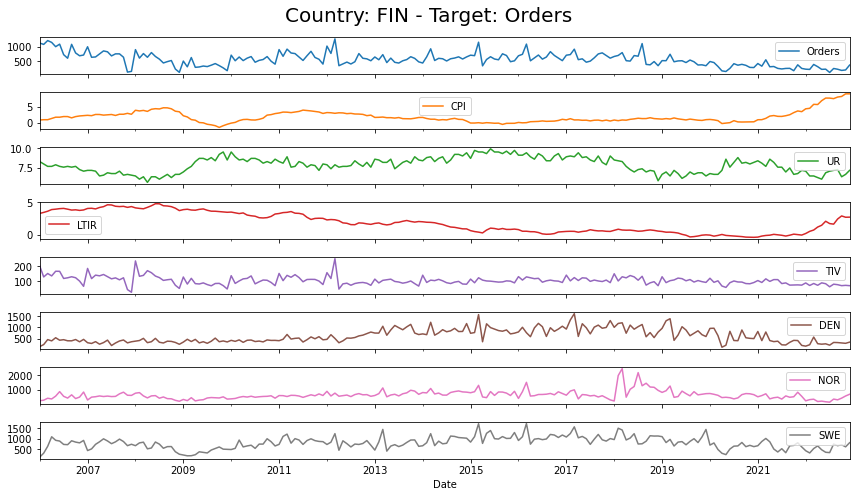

In [12]:
# Plot time series
fig, ax = plt.subplots(figsize=(12, 7))
df.plot(
    legend   = True,
    subplots = True, 
    sharex   = True,
    ax       = ax, 
)
fig.suptitle('Country: ' + country + ' - Target: ' + dep_var, fontsize=20)
fig.tight_layout();

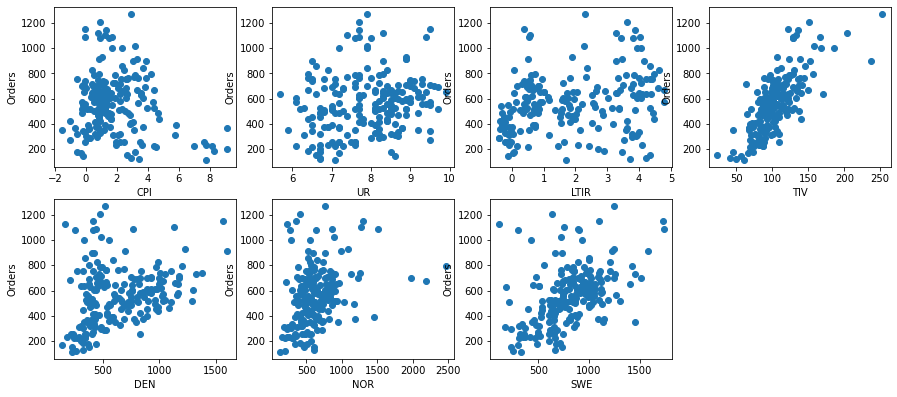

In [13]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    
    ind_var = df.loc[:, df.columns != dep_var]  # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(15, 10))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        plt.subplot(num_rows, num_cols, fig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(df,4)

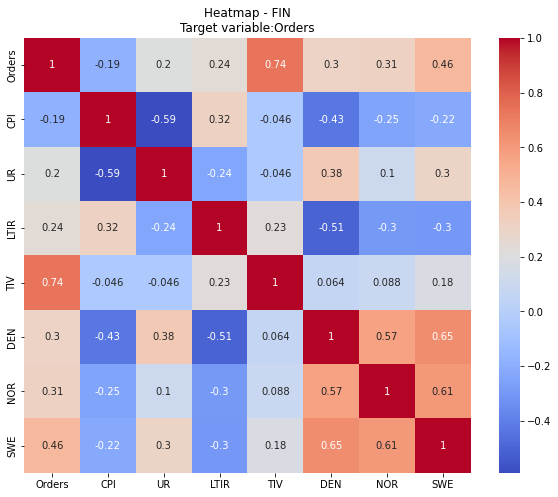

In [14]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 8))
ax = plt.axes()
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2g', ax=ax)
ax.set_title('Heatmap - ' + country + '\nTarget variable:'  +dep_var)
plt.show()

### Orders distribution

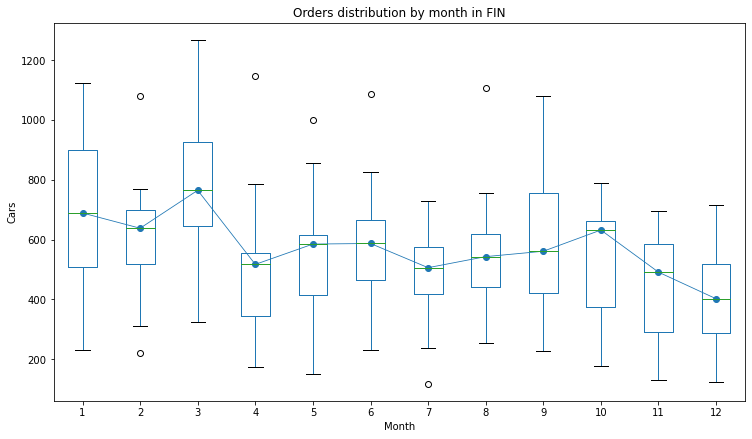

In [15]:
# Boxplot for annual seasonality
fig, ax = plt.subplots(figsize=(12, 7))
df['Month'] = df.index.month
df.boxplot(column=dep_var, by='Month', ax=ax,)
df.groupby('Month')[dep_var].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Cars')
ax.set_title(dep_var + ' distribution by month in ' + country)
fig.suptitle('');
df.drop('Month', axis=1, inplace=True)

### Correlation plots

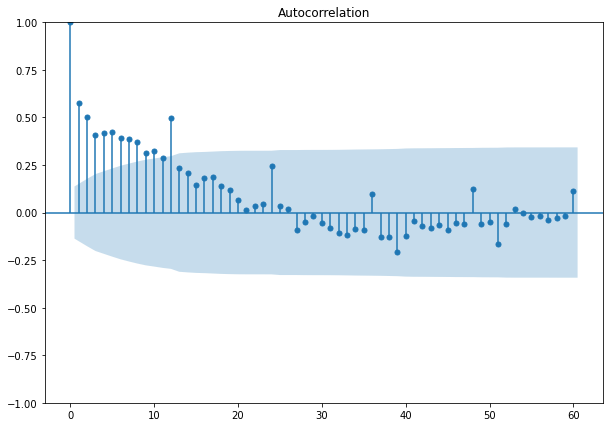

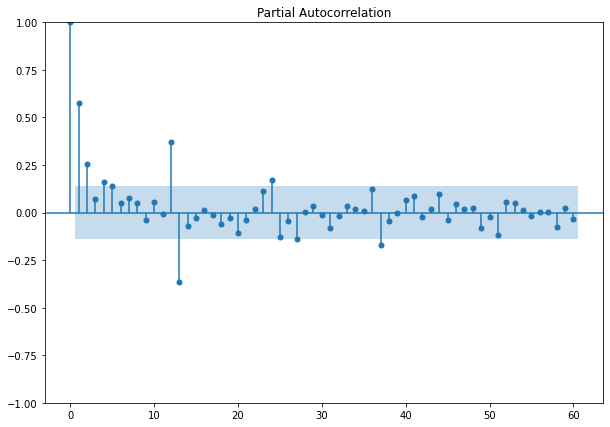

In [16]:
# Autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_acf(df[dep_var], ax=ax, lags=60)

# Partial autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 7))
plot_pacf(df[dep_var], ax=ax, lags=60, method='ywm')
plt.show()

### Trend

Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

In [17]:
# Determine rolling statistics
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
window_size = 12
df["rolling_avg"] = df[dep_var].rolling(window=window_size).mean() 
df["rolling_std"] = df[dep_var].rolling(window=window_size).std()

title = 'Rolling Mean & Standard Deviation - ' + country

fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=df[dep_var], mode='lines', name= 'Original')))
fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=df['rolling_avg'], mode='lines', name= 'Rolling Mean')))
fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=df['rolling_std'], mode='lines', name= 'Rolling Std')))

fig.update_layout(height=400, width=1200, title=go.layout.Title(text=title),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))

fig.show()

df.drop(['rolling_avg', 'rolling_std'], axis=1, inplace=True)

### Time series decomposition 

We separate a time series into its components: trend, seasonality, and residuals. The trend represents the slow-moving changes in a time series. It is responsible for making the series gradually increase or decrease over time. The seasonality component represents the seasonal pattern in the series. The cycles occur repeatedly over a fixed period of time. The residuals represent the behavior that cannot be explained by the trend and seasonality components. They correspond to random errors, also termed white noise.

In [18]:
df.columns

Index(['Orders', 'CPI', 'UR', 'LTIR', 'TIV', 'DEN', 'NOR', 'SWE'], dtype='object')

In [19]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition - " + country):
    x_values = dates
    return (
        make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.observed, mode="lines", name='Observed'), row=1, col=1,)
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.trend, mode="lines", name='Trend'), row=2, col=1,)
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.seasonal, mode="lines", name='Seasonal'), row=3, col=1,)
        .add_trace(go.Scatter(x=x_values.to_timestamp(), y=result.resid, mode="lines", name='Residual'), row=4, col=1,)
        .update_layout(height=800, width=1000, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False)
        .update_xaxes(dtick="M6",tickformat="%b\n%Y")        
    )

decomposition = seasonal_decompose(df[dep_var], model='multiplicative', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()    

### Stationarity (Augmented Dickey–Fuller Test)

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

* Null Hypothesis: The data is not stationary.

* Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

* p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -1.422679
p-value                          0.571356
#Lags Used                      13.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


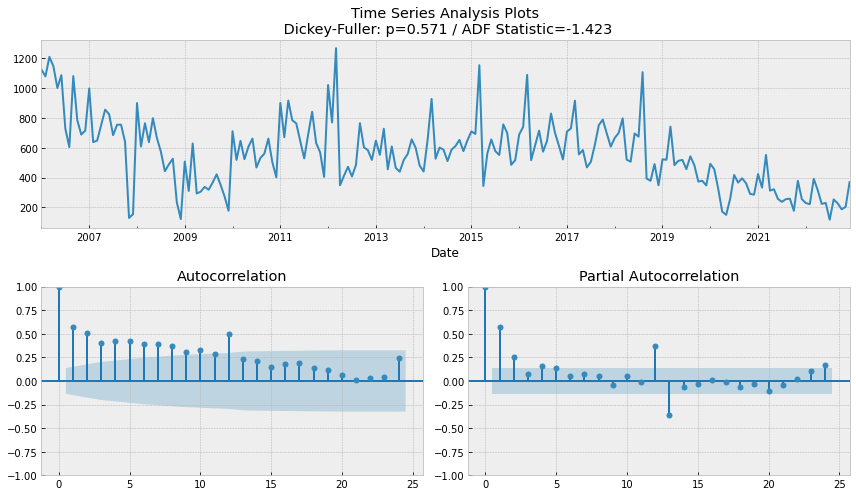

In [20]:
# Time series analysis plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = adfuller(y, autolag='AIC',regression='c')
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
# Data Stationarity check using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries, print_out:bool):    
    dftest = adfuller(timeseries, autolag='AIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if print_out:
        print ('Results of Dickey-Fuller Test:')
        print (dfoutput)    
    return dfoutput['p-value']

tsplot(df[dep_var])

p_value = adf_test(df[dep_var], True)     

Results of Dickey-Fuller Test:
Test Statistic                  -4.769177
p-value                          0.000062
#Lags Used                      12.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


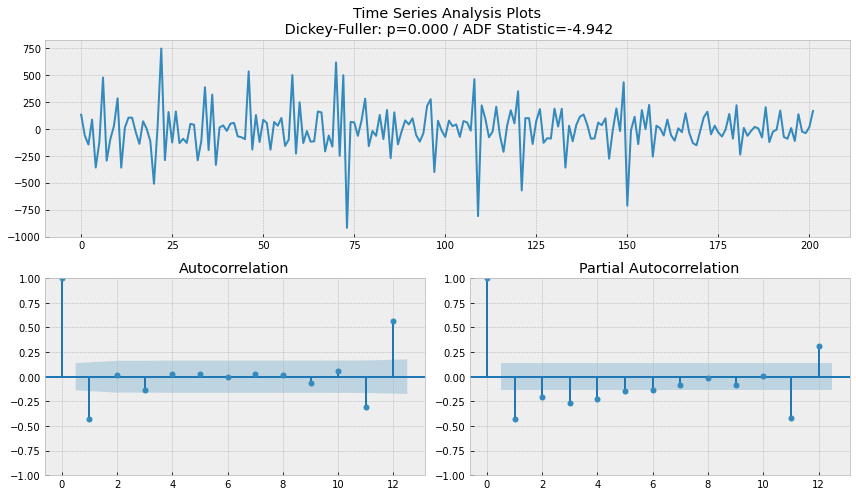

In [21]:
if p_value > 0.05:
    # Take the first difference to make our series stationary    
    data_diff = np.diff(df[dep_var],1)
    tsplot(data_diff[1:], lags=12)
    p_value = adf_test(data_diff, True)  

In [22]:
# Feature selection df
df_fe = df.copy()

### Feature Engineering

In [23]:
# Aply difference 
for c in df_fe.columns:
    p = adf_test(df_fe[c], False)   
    if p > 0.05:
        print(c + ' is not stationary')
        # Apply first difference to stationarize and detrend
        df_fe[c + '_diff'] = df_fe[c].diff(1)
        df_fe.drop([c], axis=1, inplace=True)
        df_fe = df_fe.rename(columns={c + '_diff': c})    
        df_fe.dropna(inplace=True)    
    else:
        print(c + ' is stationary')

Orders is not stationary
CPI is not stationary
UR is stationary
LTIR is not stationary
TIV is not stationary
DEN is not stationary
NOR is not stationary
SWE is not stationary


In [24]:
# Verify difference 
for c in df_fe.columns:
    p = adf_test(df_fe[c], False)   
    if p > 0.05:
        print(c + ' is not stationary')        
    else:
        print(c + ' is stationary')

UR is stationary
Orders is stationary
CPI is stationary
LTIR is stationary
TIV is stationary
DEN is stationary
NOR is stationary
SWE is stationary


In [25]:
df_fe

,UR,Orders,CPI,LTIR,TIV,DEN,NOR,SWE
Date,,,,,,,,
2006-08,7.7,-123.0,-0.007631,-0.120000,4.466132,-48.0,-123.0,-12.0
2006-09,7.6,476.0,-0.407463,-0.140000,7.289168,-2.0,226.0,189.0
2006-10,7.7,-295.0,0.399893,0.040000,-6.693684,57.0,-260.0,-64.0
2006-11,7.3,-97.0,0.203378,-0.090000,-23.058473,-100.0,105.0,-37.0
2006-12,7.1,26.0,0.099801,0.070000,-35.762137,106.0,348.0,118.0
...,...,...,...,...,...,...,...,...
2022-08,7.2,136.0,-0.169369,-0.088953,17.765280,118.0,214.0,415.0
2022-09,7.3,-26.0,0.503214,0.795932,-3.451603,-6.0,-52.0,-78.0
2022-10,6.4,-40.0,0.191470,0.473650,-6.649574,-15.0,118.0,45.0


In [26]:
# Create Lagged target variables 1m to 12m
columns = df_fe.columns.difference([dep_var])
range = np.arange(1,13)
for r in range:
    df_fe[dep_var + '_lag' + str(r)] = df_fe[dep_var].shift(r)    

In [27]:
columns

Index(['CPI', 'DEN', 'LTIR', 'NOR', 'SWE', 'TIV', 'UR'], dtype='object')

In [28]:
# Create lagged variables of the exogenoues features
range = [1,3,6,9,12]
for r in range:
    for c in columns:
        df_fe[c + '_lag' + str(r)] = df_fe[c].shift(r)

In [29]:
# Feature engineering - Seasonal patterns
df_fe['Quarter'] = pd.PeriodIndex(df_fe.index, freq='Q').quarter
df_fe['Month'] = pd.PeriodIndex(df_fe.index, freq='M').month
df_fe['Year'] = pd.PeriodIndex(df_fe.index, freq='Y').year

In [30]:
# OneHot Encoding
df_fe = pd.get_dummies(df_fe, columns=['Quarter','Month','Year'], drop_first=True)

In [31]:
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
window_size = 12
df_fe["rolling_avg"] = df_fe[dep_var].rolling(window=window_size).mean() 
df_fe["rolling_std"] = df_fe[dep_var].rolling(window=window_size).std()

In [32]:
df_fe.shape

(197, 87)

In [33]:
df_fe = df_fe.dropna()

In [34]:
df_fe.columns

Index(['UR', 'Orders', 'CPI', 'LTIR', 'TIV', 'DEN', 'NOR', 'SWE',
       'Orders_lag1', 'Orders_lag2', 'Orders_lag3', 'Orders_lag4',
       'Orders_lag5', 'Orders_lag6', 'Orders_lag7', 'Orders_lag8',
       'Orders_lag9', 'Orders_lag10', 'Orders_lag11', 'Orders_lag12',
       'CPI_lag1', 'DEN_lag1', 'LTIR_lag1', 'NOR_lag1', 'SWE_lag1', 'TIV_lag1',
       'UR_lag1', 'CPI_lag3', 'DEN_lag3', 'LTIR_lag3', 'NOR_lag3', 'SWE_lag3',
       'TIV_lag3', 'UR_lag3', 'CPI_lag6', 'DEN_lag6', 'LTIR_lag6', 'NOR_lag6',
       'SWE_lag6', 'TIV_lag6', 'UR_lag6', 'CPI_lag9', 'DEN_lag9', 'LTIR_lag9',
       'NOR_lag9', 'SWE_lag9', 'TIV_lag9', 'UR_lag9', 'CPI_lag12', 'DEN_lag12',
       'LTIR_lag12', 'NOR_lag12', 'SWE_lag12', 'TIV_lag12', 'UR_lag12',
       'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year

### Feature Selection

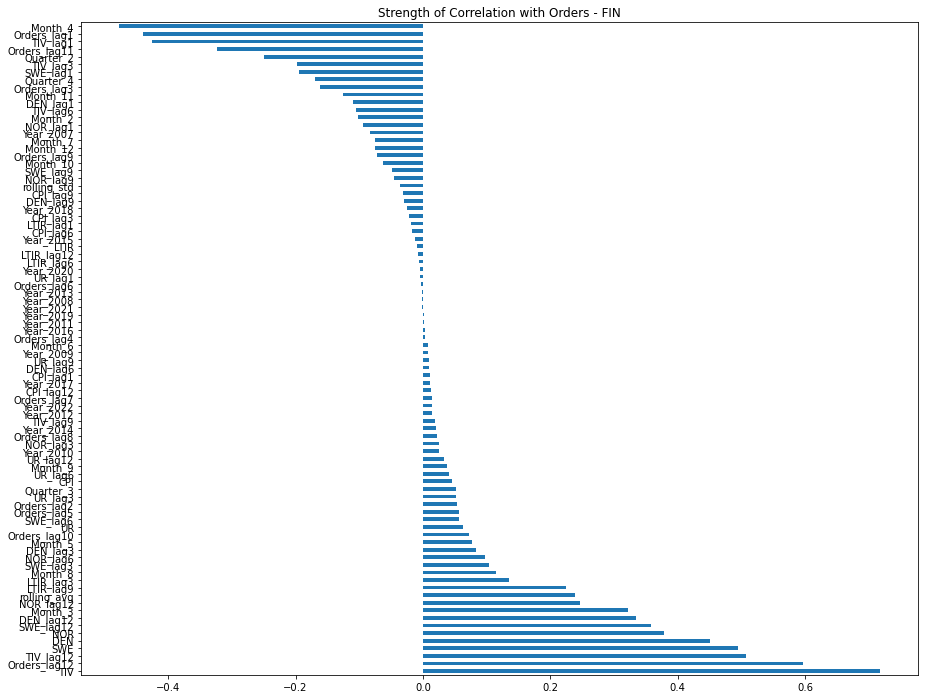

In [35]:
figure(figsize=(15, 12))

corr = df_fe.loc[:, df_fe.columns != dep_var].corrwith(df_fe[dep_var])
corr.sort_values(ascending=False).plot.barh(title = 'Strength of Correlation with ' + dep_var + ' - ' + country);

In [36]:
#Correlation with output variable using Pearson Correlation
threshold = 0.49
cor = df_fe.corr()
cor_target = abs(cor[dep_var])

#Selecting highly correlated features
relevant_features = cor_target[(cor_target > threshold)].to_frame()
relevant_features.sort_values(by=dep_var, ascending=False)

,Orders
Orders,1.000000
TIV,0.717710
Orders_lag12,0.596953
TIV_lag12,0.507268
SWE,0.494555


In [37]:
# Keep only meaningful features
if feature_selection:
    df_fe = df_fe[relevant_features.index]

In [38]:
df_fe

,Orders,TIV,SWE,Orders_lag12,TIV_lag12
Date,,,,,
2007-08,70.0,6.506217,89.0,-123.0,4.466132
2007-09,0.0,-13.277093,132.0,476.0,7.289168
2007-10,-115.0,13.872577,-117.0,-295.0,-6.693684
2007-11,-510.0,-80.787363,-200.0,-97.0,-23.058473
2007-12,25.0,-18.261517,68.0,26.0,-35.762137
...,...,...,...,...,...
2022-08,136.0,17.765280,415.0,18.0,4.620517
2022-09,-26.0,-3.451603,-78.0,3.0,-15.118683
2022-10,-40.0,-6.649574,45.0,-81.0,0.860144


In [39]:
if feature_engineering:
    df = df_fe.copy()

In [40]:
df

,Orders,TIV,SWE,Orders_lag12,TIV_lag12
Date,,,,,
2007-08,70.0,6.506217,89.0,-123.0,4.466132
2007-09,0.0,-13.277093,132.0,476.0,7.289168
2007-10,-115.0,13.872577,-117.0,-295.0,-6.693684
2007-11,-510.0,-80.787363,-200.0,-97.0,-23.058473
2007-12,25.0,-18.261517,68.0,26.0,-35.762137
...,...,...,...,...,...
2022-08,136.0,17.765280,415.0,18.0,4.620517
2022-09,-26.0,-3.451603,-78.0,3.0,-15.118683
2022-10,-40.0,-6.649574,45.0,-81.0,0.860144


### Split Data

In [41]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

print('\nData shape:', train.shape, test.shape)

# Select input and target variables
X_train = train.drop(dep_var, axis=1)
y_train = train[dep_var]

X_test = test.drop(dep_var, axis=1)
y_test = test[dep_var]

print('\nTrain shape:', X_train.shape, y_train.shape)
print('\nTest shape:', X_test.shape, y_test.shape)

Dataset length : (n=185)
Train dates    : 2007-08 --- 2019-12  (n=149)
Test dates     : 2020-01 --- 2022-12  (n=36)

Data shape: (149, 5) (36, 5)

Train shape: (149, 4) (149,)

Test shape: (36, 4) (36,)


### Scoring Function

In [42]:
# Function to revert the first differencing
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        #print(df_train[col].iloc[-1])
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [43]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, dataframe, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        # Plot only test set
        fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index.to_timestamp(), y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
                
        # Plot whole data                
        #fig.add_trace(go.Scatter(dict(x=train.index.to_timestamp(), y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)   
        fig.add_trace(go.Scatter(dict(x=train.index.to_timestamp(), y=dataframe[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)   
        fig.add_trace(go.Scatter(dict(x=test.index.to_timestamp(), y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index.to_timestamp(), y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions (Country: " + country + ' - Target variable: ' + dep_var + ')')    

        fig.show()         

In [44]:
def plot_metrics(m, w, h):
    chart = m.transpose()
    chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

    ax = chart.plot.bar(title="Models Performance (" + country + ' /  ' 
        + dep_var + ')\nFeature Engineering:' + str(feature_engineering) 
        + ' / feature Selection: ' + str(feature_selection)
        + ' / Include Nordics: ' + str(include_nordics), 
        figsize=(w, h))
    for c in ax.containers:        
        ax.bar_label(c, fmt='%0.2f', label_type='edge', padding=5)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

### ML Models

In [45]:
# Hyperparameters
modelclasses = [
    ["Extra Tree", ExtraTreesRegressor],
    ["XGBoost", XGBRegressor],
    ["Gradient Boosting", GradientBoostingRegressor],
    ["Random Forest", RandomForestRegressor],
    ["Ada Boost", AdaBoostRegressor],
    ["LightGBM", LGBMRegressor],
    ["Decision Tree", DecisionTreeRegressor]
]

for model_name, Model in modelclasses:
    
    # Instantiate the model
    model = Model()
    
    # Fit 
    model.fit(X_train,y_train)
        
    # Predict
    y_pred = model.predict(X_test) 

    if feature_engineering:

        # Create dataframe of predictions
        y_pred_df = pd.DataFrame(data=y_pred, index=test.index, columns=[dep_var])

        # Invert transformation
        y_pred_df_inv = invert_transformation(df_original[[dep_var]].iloc[:-steps],y_pred_df)

        # Score
        scoring(model_name, df_original[[dep_var]].iloc[-steps:].squeeze(), y_pred_df_inv[dep_var + '_forecast'].values, df_original, True, True)

    else:

        # Score
        scoring(model_name, y_test, y_pred, df, True, True)

Extra Tree Model Performance:
Mean Absolute Error: 265.34.
Mean Squared Error: 76531.11.
Root Mean Squared Error: 276.64.
R^2 Score = -6.99.
Mean Absolute Percentage Error: 95.97%.
Accuracy = 4.03%.


XGBoost Model Performance:
Mean Absolute Error: 131.52.
Mean Squared Error: 24071.90.
Root Mean Squared Error: 155.15.
R^2 Score = -1.51.
Mean Absolute Percentage Error: 48.32%.
Accuracy = 51.68%.


Gradient Boosting Model Performance:
Mean Absolute Error: 354.41.
Mean Squared Error: 158551.77.
Root Mean Squared Error: 398.19.
R^2 Score = -15.56.
Mean Absolute Percentage Error: 143.98%.
Accuracy = -43.98%.


Random Forest Model Performance:
Mean Absolute Error: 102.94.
Mean Squared Error: 16703.24.
Root Mean Squared Error: 129.24.
R^2 Score = -0.74.
Mean Absolute Percentage Error: 34.58%.
Accuracy = 65.42%.


Ada Boost Model Performance:
Mean Absolute Error: 378.85.
Mean Squared Error: 193009.29.
Root Mean Squared Error: 439.33.
R^2 Score = -19.16.
Mean Absolute Percentage Error: 158.94%.
Accuracy = -58.94%.


LightGBM Model Performance:
Mean Absolute Error: 345.28.
Mean Squared Error: 168002.93.
Root Mean Squared Error: 409.88.
R^2 Score = -16.55.
Mean Absolute Percentage Error: 138.83%.
Accuracy = -38.83%.


Decision Tree Model Performance:
Mean Absolute Error: 235.28.
Mean Squared Error: 85377.22.
Root Mean Squared Error: 292.19.
R^2 Score = -7.92.
Mean Absolute Percentage Error: 98.10%.
Accuracy = 1.90%.


In [46]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

df_forecast=pd.DataFrame(data=y_pred, index=test.index, columns=[dep_var])
df_inv = invert_transformation(train[[dep_var]], df_forecast)
df_inv.insert(2, "Original", test[[dep_var]])
df_inv

,Orders,Orders_forecast,Original
Date,,,
2020-01,187.0,535.0,493
2020-02,51.0,586.0,457
2020-03,280.0,866.0,325
2020-04,-292.0,574.0,172
2020-05,-130.0,444.0,151
2020-06,29.0,473.0,259
2020-07,46.0,519.0,418
2020-08,-130.0,389.0,367
2020-09,46.0,435.0,396


In [47]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,265.344444,131.517476,354.408033,102.940833,378.852358,345.280390,235.277778
Mean Squared Error,76531.105678,24071.898701,158551.773427,16703.242758,193009.289339,168002.931039,85377.222222
Root Mean Squared Error,276.642559,155.151212,398.185602,129.241026,439.328225,409.881606,292.193809
R^2,-6.993184,-1.514156,-15.559718,-0.744547,-19.158585,-16.546831,-7.917104
Mean Absolute Percentage Error,95.969747,48.323753,143.975548,34.584951,158.940385,138.831848,98.098482
Accuracy,4.030253,51.676247,-43.975548,65.415049,-58.940385,-38.831848,1.901518


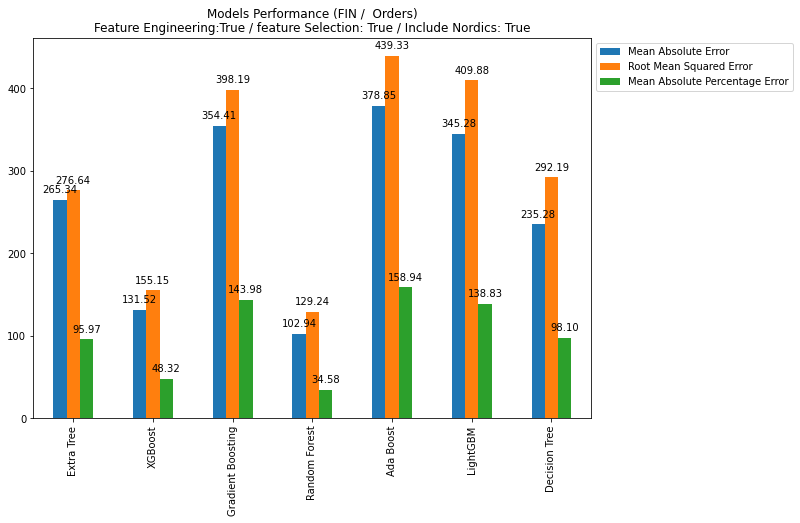

In [48]:
plot_metrics(metrics, 10, 7)

### Statistical Models

In [49]:
start=len(train)
end=len(train)+len(test)-1

In [50]:
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

# Feature engineering - Seasonal patterns
df['Quarter'] = pd.PeriodIndex(df.index, freq='Q').quarter

# Load files into a pandas dataframes
file = path + 'target.xlsx'
df_nordics = pd.read_excel(file, sheet_name=dep_var)

# Set index
df_nordics = df_nordics.set_index("Date")
df_nordics.index = pd.PeriodIndex(df_nordics.index, freq="M")

#Merge dataframes
df = pd.merge(df, df_nordics[df_nordics.columns.difference([country])], left_index=True, right_index=True)

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

print('\nData shape:', train.shape, test.shape)

# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

# Select input and target variables
X_train = train.drop(dep_var, axis=1)
y_train = train[dep_var]

X_test = test.drop(dep_var, axis=1)
y_test = test[dep_var]

print('\nTrain shape:', X_train.shape, y_train.shape)
print('\nTest shape:', X_test.shape, y_test.shape)


Dataset length : (n=204)
Train dates    : 2006-01 --- 2019-12  (n=168)
Test dates     : 2020-01 --- 2022-12  (n=36)

Data shape: (168, 5) (36, 5)

Train shape: (168, 8) (168,)

Test shape: (36, 8) (36,)


In [51]:
df

,Orders,CPI,UR,LTIR,TIV,Quarter,DEN,NOR,SWE
Date,,,,,,,,,
2006-01,1124,0.807265,8.3,3.280000,203.413007,1,161,233,110
2006-02,1079,0.901804,8.0,3.440000,128.084250,1,250,270,303
2006-03,1210,0.899101,7.7,3.620000,151.605878,1,468,406,634
2006-04,1147,1.297405,7.7,3.880000,135.086704,2,412,356,1097
2006-05,1001,1.701702,7.9,3.940000,166.978193,2,550,553,926
...,...,...,...,...,...,...,...,...,...
2022-08,254,7.616082,7.2,1.624904,78.449535,3,343,347,744
2022-09,228,8.119296,7.3,2.420836,74.997932,3,337,295,666
2022-10,188,8.310766,6.4,2.894486,68.348358,4,322,413,711


#### Triple Exponential Smoothing

In [52]:
model_name='Triple Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal='add',seasonal_periods=12).fit()

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)

Triple Exponential Smoothing Model Performance:
Mean Absolute Error: 100.96.
Mean Squared Error: 16591.50.
Root Mean Squared Error: 128.81.
R^2 Score = -0.73.
Mean Absolute Percentage Error: 40.72%.
Accuracy = 59.28%.


#### SARIMA

In [53]:
# Seasonal - fit stepwise auto-ARIMA
model = auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

model_name='SARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)                    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1999.944, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2084.475, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2039.583, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2002.150, Time=0.24 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2043.561, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2001.868, Time=0.54 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2001.830, Time=1.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2017.834, Time=0.29 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2022.606, Time=0.29 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2001.822, Time=0.64 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2001.860, Time=0.52 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2041.516, Time=0.16 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1999.922, Time=0.34 sec
 ARIMA(0,1,2)(0,1,0)[12]

#### SARIMAX

In [54]:
train

,Orders,CPI,UR,LTIR,TIV,Quarter,DEN,NOR,SWE
Date,,,,,,,,,
2006-01,1124,0.807265,8.3,3.28,203.413007,1,161,233,110
2006-02,1079,0.901804,8.0,3.44,128.084250,1,250,270,303
2006-03,1210,0.899101,7.7,3.62,151.605878,1,468,406,634
2006-04,1147,1.297405,7.7,3.88,135.086704,2,412,356,1097
2006-05,1001,1.701702,7.9,3.94,166.978193,2,550,553,926
...,...,...,...,...,...,...,...,...,...
2019-08,543,1.093964,7.0,-0.35,110.208695,3,637,571,874
2019-09,484,0.916179,6.7,-0.30,93.060954,3,744,862,1004
2019-10,374,0.748663,6.9,-0.21,103.338571,4,853,641,816


In [55]:
exo_train = train.loc[:, train.columns == 'DEN']
exo_test = test.loc[:, test.columns == 'DEN']

In [56]:
# SARIMAX = SARIMA with exogenous variable
#exo_train = train.loc[:, train.columns != dep_var]
#exo_test = test.loc[:, test.columns != dep_var]
model = auto_arima(train[dep_var], exogenous=exo_train,
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

model_name='SARIMAX'

# Predict
predictions = model.predict(n_periods=test.shape[0], exog=exo_test,  dynamic=False, typ='levels')

# Forecast accuracy
scoring(model_name, test[dep_var], predictions, df, True, True)                           

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1999.944, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2084.475, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2039.583, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2002.150, Time=0.23 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2043.561, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2001.868, Time=0.54 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2001.830, Time=1.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2017.834, Time=0.29 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2022.606, Time=0.25 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2001.822, Time=0.60 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2001.860, Time=0.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2041.516, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1999.922, Time=0.33 sec
 ARIMA(0,1,2)(0,1,0)[12]

### Results

In [57]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree,Triple Exponential Smoothing,SARIMA,SARIMAX
Mean Absolute Error,265.344444,131.517476,354.408033,102.940833,378.852358,345.280390,235.277778,100.956312,105.274896,105.274896
Mean Squared Error,76531.105678,24071.898701,158551.773427,16703.242758,193009.289339,168002.931039,85377.222222,16591.499503,17932.820898,17932.820898
Root Mean Squared Error,276.642559,155.151212,398.185602,129.241026,439.328225,409.881606,292.193809,128.807995,133.913483,133.913483
R^2,-6.993184,-1.514156,-15.559718,-0.744547,-19.158585,-16.546831,-7.917104,-0.732876,-0.872968,-0.872968
Mean Absolute Percentage Error,95.969747,48.323753,143.975548,34.584951,158.940385,138.831848,98.098482,40.722514,42.919213,42.919213
Accuracy,4.030253,51.676247,-43.975548,65.415049,-58.940385,-38.831848,1.901518,59.277486,57.080787,57.080787


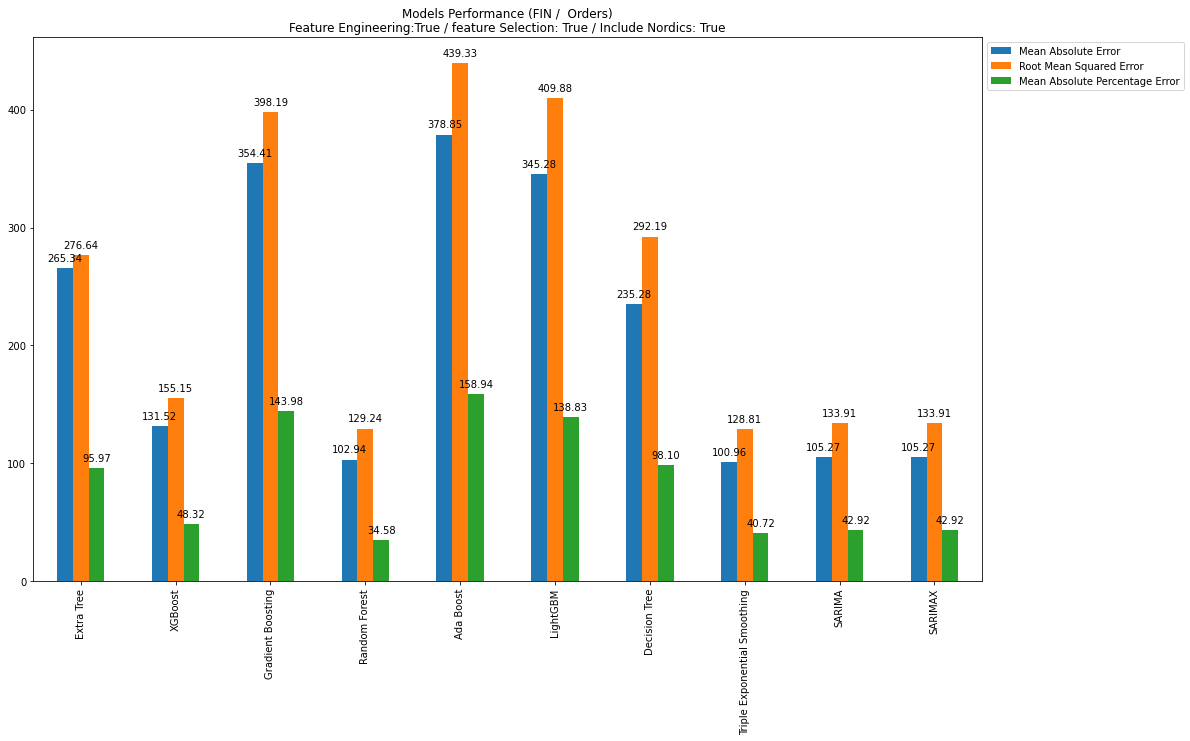

In [58]:
plot_metrics(metrics, 17, 10)